In [148]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import tarfile
import urllib
import email
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [70]:
DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("dataset", "spam")

def get_spam_data(spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
        
    for filename, url in (("ham.tar.bz2", HAM_URL), ("spam.tar.bz2", SPAM_URL)):
        path = os.path.join(spam_path, filename)
        
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
            
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=SPAM_PATH)
        tar_bz2_file.close()

In [71]:
get_spam_data()

In [80]:
raw_data = []
labels = []
invalid_list = []

In [84]:
def process_email(body):
    body_pp = body.lower()
    body_pp = re.sub(r"(http|https)://[^\s]*", ' httpaddr ', body_pp)
    body_pp = re.sub(r"[^\s]+@[^\s]+", ' emailaddr ', body_pp)
    body_pp = re.sub(' html ',' ', body_pp)
    
    return body_pp

def process_folder(path, label):
    for filename in os.listdir(path):
        try:
            file = open(path + filename,'r', errors='ignore')
            content = file.read()

            msg = email.message_from_string(content)
            
            if msg.is_multipart():
                body = []
                
                for payload in msg.get_payload():
                    body.append(payload.get_payload())
                    
                body = ' '.join(body)

            else:
                body = msg.get_payload()
                
            body = processemail(body)
            raw_data.append(body)
            labels.append(label)
            
        except:
            invalid_list.append(filename)

In [85]:
SPAM_PATH = 'D:/kodzik/spam_classifier/dataset/spam/spam/'
HAM_PATH = 'D:/kodzik/spam_classifier/dataset/spam/easy_ham/'

process_folder(SPAM_PATH, 1)
process_folder(HAM_PATH, 0)
print(f'Total email count: {len(raw_data)}')
print(f'Total labels: {len(labels)}')

Total email count: 5982
Total labels: 5982


In [88]:
print(raw_data[21])

urgent private   extremely confidential    dear   number c  with profound interest and in utmost confidence  number c i am soliciting your immediate assistance or co operation as to enable us round up an opportunity within my capability as a result of the death of one of our contractor   number beneficiary  number   number e you should not be surprised as to how i got your contact  number c you were highly recommended to me with the believe that you are competent  number c reliable  number c trustworthy and confident  number e  i am  dr  number e bello ahmed  number c chief auditor  number c special project and foreign contract regularization and disbursement  number c in the office of the auditor general of the federation of federal republic of nigeria  number e we work in hand with the senate committee on foreign contract payment  number e our duty is to ensure that all contractors are paid their contract sum in due time  number e  this last payment quarter  number c a total of  numb

In [101]:
X_train, X_test, y_train, y_test = train_test_split(raw_data, labels, test_size=0.2)

In [102]:
vectorizer = TfidfVectorizer()

In [103]:
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [114]:
model_svm = SVC()

In [122]:
C = [0.01, 0.1, 0.2, 0.5, 1, 2]
kernel = ['linear', 'poly', 'rbf', 'sigmoid']
gamma = ['scale', 'auto']

param_grid = {'C' : C, 'kernel' : kernel, 'gamma' : gamma}

In [125]:
grid_search = GridSearchCV(model_svc, param_grid, cv=5, scoring='roc_auc',
                          return_train_score=True)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.01, 0.1, 0.2, 0.5, 1, 2],
                         'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             return_train_score=True, scoring='roc_auc')

In [126]:
grid_search.best_params_

{'C': 2, 'gamma': 'scale', 'kernel': 'linear'}

In [151]:
model = grid_search.best_estimator_

In [152]:
y_pred = model.predict(X_test)

In [161]:
acc = accuracy_score(y_pred, y_test)
roc_auc = roc_auc_score(y_pred, y_test)
print(f'roc_auc: {roc_auc}')
print(f'accuracy: {acc}')

roc_auc: 0.9948971094896589
accuracy: 0.9949874686716792


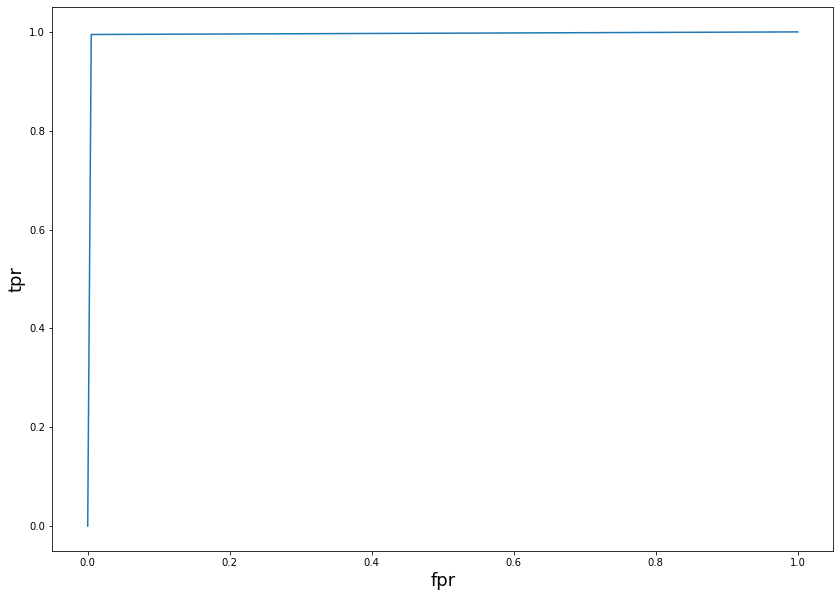

In [155]:
fpr, tpr, thrshds = roc_curve(y_pred, y_test)
plt.figure(figsize=(14,10))
plt.plot(fpr, tpr)
plt.xlabel('fpr', fontsize=18)
plt.ylabel('tpr', fontsize=18)
plt.show()

<AxesSubplot:>

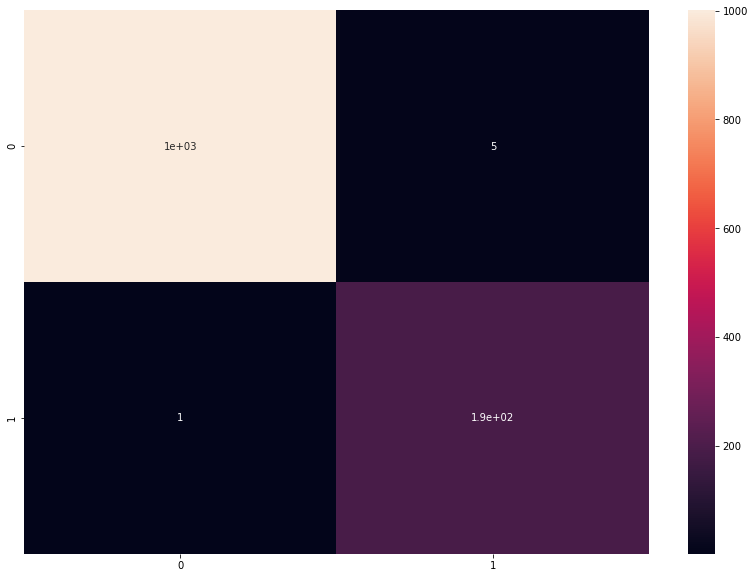

In [156]:
cnf_mtx = confusion_matrix(y_pred, y_test)
plt.figure(figsize=(14,10))
sns.heatmap(cnf_mtx, annot=True)